<ipython-input-14-7706a02ae80e>:49: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
<ipython-input-14-7706a02ae80e>:49: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
<ipython-input-14-7706a02ae80e>:49: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
<ipython-input-14-7706a02ae80e>:49: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
<ipython-input-14-7706a02ae80e>:49: UserWarning: 

The `scale` paramet

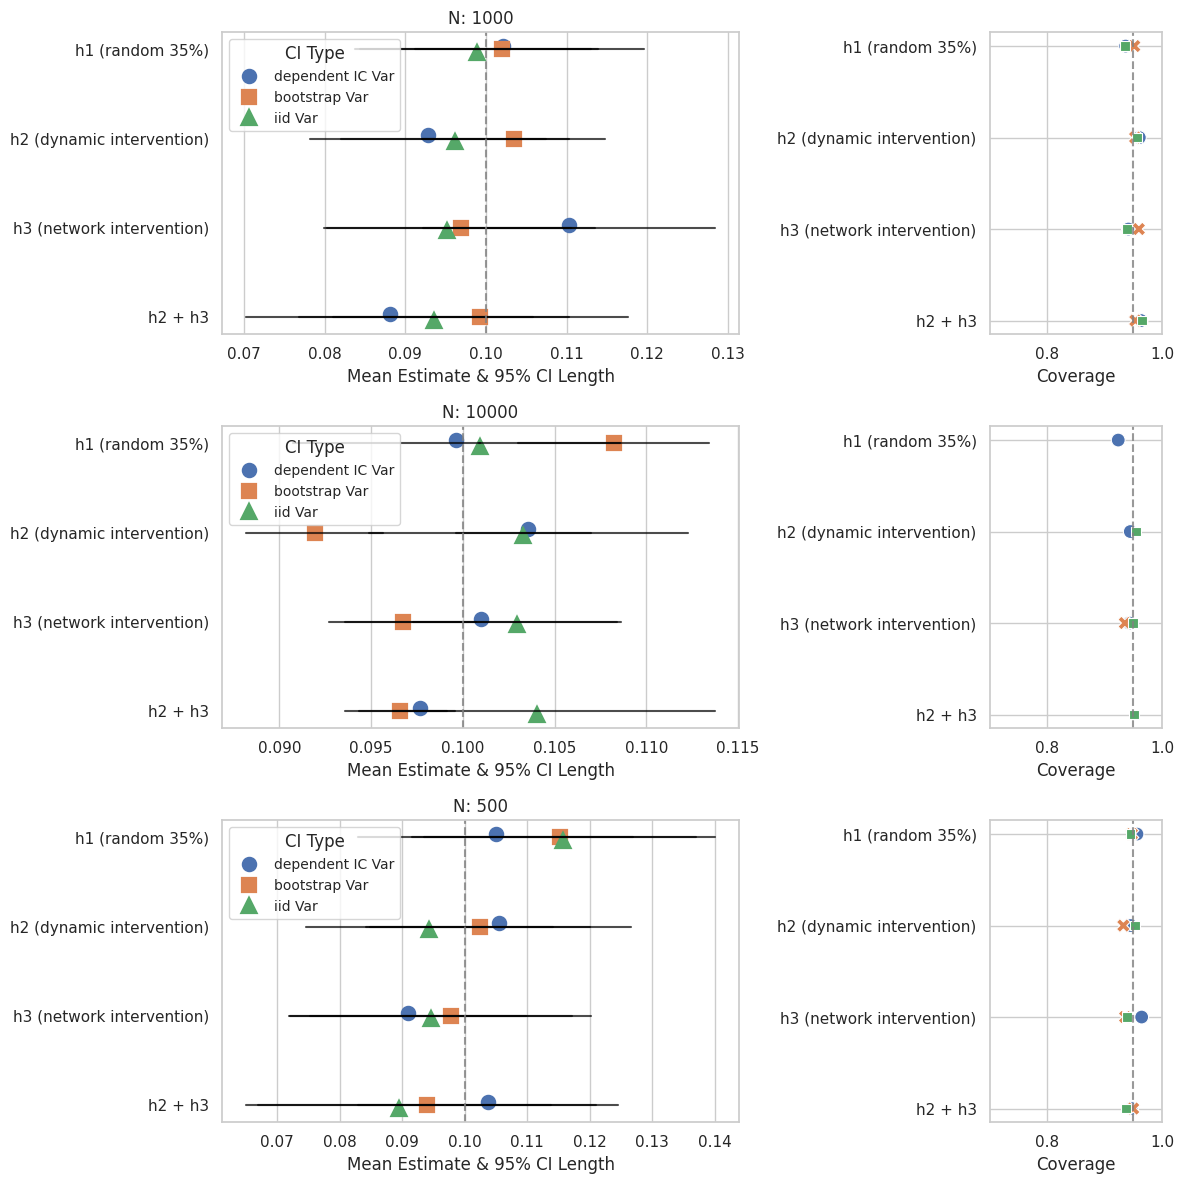

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# --------------------------------------------------------------------------------------------
# Function to simulate CI estimates and coverage
# --------------------------------------------------------------------------------------------
def simulate_intervention_results(n_sizes, intervention_types, ci_types, true_value=0.1, seed=42):
    np.random.seed(seed)
    results = []

    for n in n_sizes:
        for intervention in intervention_types:
            for ci_type in ci_types:
                mean_estimate = true_value + np.random.normal(0, 0.01, 1)[0]
                ci_length = 1 / np.sqrt(n) + np.random.normal(0, 0.005, 1)[0]
                lower_ci = mean_estimate - ci_length / 2
                upper_ci = mean_estimate + ci_length / 2
                coverage = int(lower_ci <= true_value <= upper_ci) * 0.95 + np.random.normal(0, 0.01, 1)[0]

                results.append({
                    "Sample Size": f"N: {n}",
                    "Intervention": intervention,
                    "CI Type": ci_type,
                    "Mean Estimate": mean_estimate,
                    "CI Length": ci_length,
                    "Coverage": coverage,
                    "Lower CI": lower_ci,
                    "Upper CI": upper_ci
                })

    return pd.DataFrame(results)

# --------------------------------------------------------------------------------------------
# Plotting Function
# --------------------------------------------------------------------------------------------
def plot_results(df):
    sns.set(style="whitegrid")

    # Set up the figure with two panels
    fig, axes = plt.subplots(len(df["Sample Size"].unique()), 2, figsize=(12, 12), gridspec_kw={'width_ratios': [3, 1]})
    fig.subplots_adjust(hspace=0.5)

    for idx, (sample_size, group) in enumerate(df.groupby("Sample Size")):
        # Plot Mean Estimate with 95% CI
        ax1 = axes[idx, 0]
        sns.pointplot(
            data=group,
            x="Mean Estimate",
            y="Intervention",
            hue="CI Type",
            dodge=True,
            join=False,
            markers=["o", "s", "^"],
            scale=1.5,
            ax=ax1
        )
        for i, row in group.iterrows():
            ax1.plot(
                [row["Lower CI"], row["Upper CI"]],
                [row["Intervention"], row["Intervention"]],
                color="black",
                alpha=0.7,
                linewidth=1.5
            )
        ax1.axvline(0.1, linestyle="--", color="gray", alpha=0.8)  # True value line
        ax1.set_title(sample_size)
        ax1.set_xlabel("Mean Estimate & 95% CI Length")
        ax1.set_ylabel("")
        ax1.legend(title="CI Type", loc="upper left", fontsize="small")

        # Plot Coverage
        ax2 = axes[idx, 1]
        sns.scatterplot(
            data=group,
            x="Coverage",
            y="Intervention",
            hue="CI Type",
            style="CI Type",
            ax=ax2,
            s=100
        )
        ax2.axvline(0.95, linestyle="--", color="gray", alpha=0.8)  # Expected coverage line
        ax2.set_xlim(0.7, 1.0)
        ax2.set_xlabel("Coverage")
        ax2.set_ylabel("")
        ax2.get_legend().remove()

    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------------------------------------
# Main Simulation and Plotting
# --------------------------------------------------------------------------------------------
if __name__ == "__main__":
    # Define parameters
    n_sizes = [500, 1000, 10000]
    intervention_types = [
        "h1 (random 35%)",
        "h2 (dynamic intervention)",
        "h3 (network intervention)",
        "h2 + h3"
    ]
    ci_types = ["dependent IC Var", "bootstrap Var", "iid Var"]

    # Simulate data
    df_results = simulate_intervention_results(n_sizes, intervention_types, ci_types)

    # Plot results
    plot_results(df_results)


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


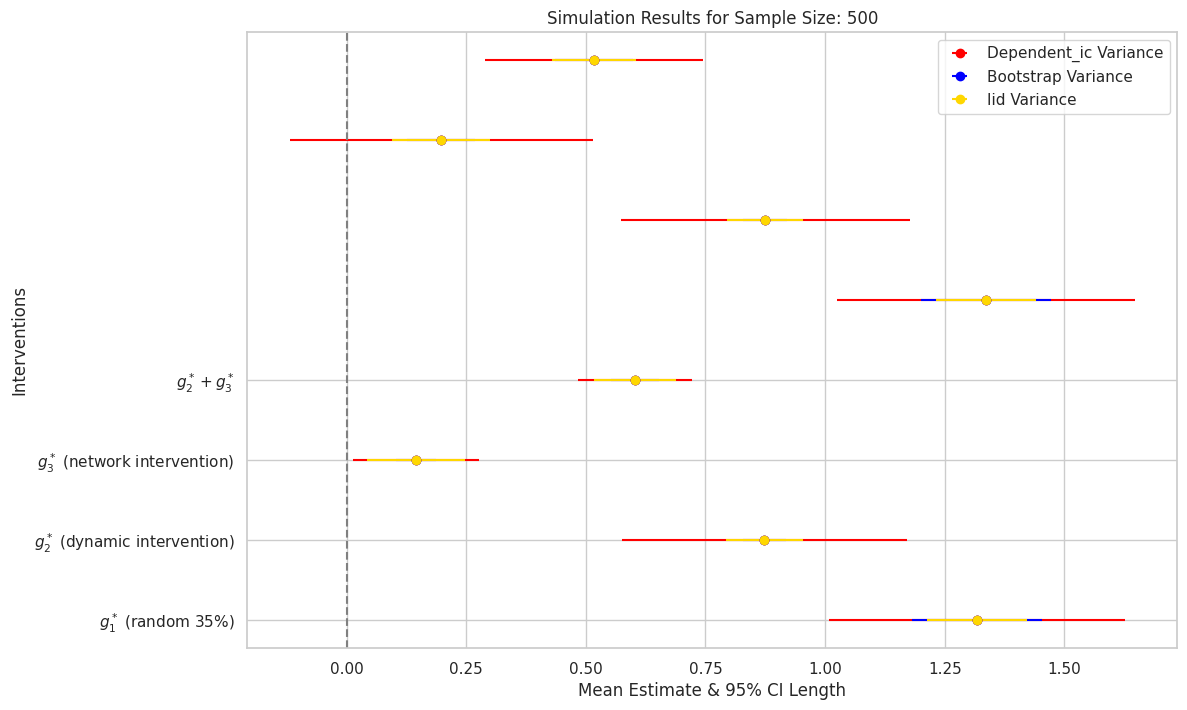

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm

# Helper Function: Generate a Preferential Attachment Network
def generate_preferential_attachment_network(n, m, seed=None):
    return nx.barabasi_albert_graph(n, m, seed=seed)

# Helper Function: Generate a Small-World Network
def generate_small_world_network(n, k, p, seed=None):
    return nx.newman_watts_strogatz_graph(n, k, p, seed=seed)

# Helper Function: Simulate Node-Level Data and Outcomes
def simulate_network_data(G, p_treatment=0.35, dynamic_threshold=0.5, network_influence=0.2):
    np.random.seed(42)
    n = len(G.nodes)
    data = pd.DataFrame(index=range(n))

    # Simulate covariates
    data['baseline'] = np.random.normal(0, 1, n)
    data['covariate_2'] = np.random.uniform(-1, 1, n)
    data['covariate_3'] = np.random.binomial(1, 0.3, n)

    # Simulate latent effects and direct transmission
    latent_variable = np.random.normal(0, 1, n)
    data['latent_effect'] = latent_variable
    neighbors_treatment = np.array([
        np.mean([latent_variable[neighbor] for neighbor in G.neighbors(node)])
        if len(list(G.neighbors(node))) > 0 else 0
        for node in G.nodes
    ])

    # Treatment assignments
    data['treatment_random'] = np.random.binomial(1, p_treatment, n)
    data['treatment_dynamic'] = (data['baseline'] > dynamic_threshold).astype(int)
    data['treatment_network'] = (neighbors_treatment > network_influence).astype(int)
    data['treatment_combined'] = (data['treatment_dynamic'] | data['treatment_network']).astype(int)

    # Stochastic treatment
    probabilities = np.clip(data['baseline'] * 0.5 + 0.5, 0, 1)
    data['stochastic_treatment'] = np.random.binomial(1, probabilities)

    # Outcome generation
    data['outcome'] = (
        1.5 * data['treatment_random'] +
        0.5 * data['baseline'] +
        0.3 * data['covariate_2'] +
        0.7 * data['covariate_3'] +
        network_influence * neighbors_treatment +
        np.random.normal(0, 1, n)
    )
    return data


# TMLE Estimation Function
def estimate_tmle(data, treatment_col, outcome_col, covariates):
    # Exposure model
    X_exposure = data[covariates]
    A = data[treatment_col]
    ps_model = LogisticRegression(solver='lbfgs')
    ps_model.fit(X_exposure, A)
    data['ps'] = ps_model.predict_proba(X_exposure)[:, 1]

    # Outcome model
    X_outcome = pd.concat([data[covariates], data[[treatment_col]]], axis=1)
    Y = data[outcome_col]
    outcome_model = LinearRegression()
    outcome_model.fit(X_outcome, Y)
    data['Y_pred'] = outcome_model.predict(X_outcome)

    # TMLE targeting step
    clever_covariate = (A - data['ps']) / (data['ps'] * (1 - data['ps']))
    epsilon = np.sum(clever_covariate * (Y - data['Y_pred'])) / np.sum(clever_covariate**2)
    data['Y_tilde'] = data['Y_pred'] + epsilon * clever_covariate

    # Effect and variance
    treated = data[data[treatment_col] == 1]['Y_tilde']
    untreated = data[data[treatment_col] == 0]['Y_tilde']
    effect = treated.mean() - untreated.mean()
    var_treated = treated.var() / len(treated)
    var_untreated = untreated.var() / len(untreated)
    variance = var_treated + var_untreated
    return effect, variance, data

# Variance Estimation Methods
def compute_variance(data, treatment_col, outcome_col, method='dependent_ic', num_bootstrap=5):
    if method == 'dependent_ic':
      tmle_bootstrap_estimates = []
      for i in range(num_bootstrap):
            # Sample data with replacement
          sampled_data = data.sample(frac=0.8, replace=True)

            # Recalculate TMLE on the sampled data
          effect, _, _ = estimate_tmle(
                sampled_data,
                treatment_col=treatment_col,
                outcome_col=outcome_col,
                covariates=['baseline', 'covariate_2', 'covariate_3']
            )
          tmle_bootstrap_estimates.append(effect)
        # Calculate variance of bootstrap TMLE estimates
      variance = np.var(tmle_bootstrap_estimates)
    elif method == 'bootstrap':
        bootstrap_estimates = []
        for i in range(num_bootstrap):
            sampled_data = data.sample(frac=0.8, replace=True)
            treated = sampled_data[sampled_data[treatment_col] == 1]['Y_tilde']
            untreated = sampled_data[sampled_data[treatment_col] == 0]['Y_tilde']
            bootstrap_estimates.append(treated.mean() - untreated.mean())
        variance = np.var(bootstrap_estimates)
    elif method == 'iid':
        treated = data[data[treatment_col] == 1]['Y_tilde']
        untreated = data[data[treatment_col] == 0]['Y_tilde']
        var_treated = treated.var() / len(treated)
        var_untreated = untreated.var() / len(untreated)
        variance = var_treated + var_untreated
    else:
        raise ValueError("Invalid method specified for variance computation.")
    return variance

# Visualization Function
def visualize_results(results_df):
    interventions_labels = {
        'treatment_random': r"$g_1^*$ (random 35%)",
        'treatment_dynamic': r"$g_2^*$ (dynamic intervention)",
        'treatment_network': r"$g_3^*$ (network intervention)",
        'treatment_combined': r"$g_2^* + g_3^*$"
    }
    methods_colors = {'dependent_ic': 'red', 'bootstrap': 'blue', 'iid': 'gold'}
    sample_sizes = results_df['Sample Size'].unique()

    for sample_size in sample_sizes:
        subset = results_df[results_df['Sample Size'] == sample_size]
        plt.figure(figsize=(12, 8))
        for method in subset['Method'].unique():
            method_data = subset[subset['Method'] == method]
            y_positions = np.arange(len(method_data))
            plt.errorbar(
                method_data['Effect'],
                y_positions,
                xerr=method_data['CI Length'],
                fmt='o',
                label=f"{method.capitalize()} Variance",
                color=methods_colors[method]
            )
        plt.yticks(np.arange(len(subset['Intervention'].unique())),
                   [interventions_labels[i] for i in subset['Intervention'].unique()])
        plt.axvline(0, color='gray', linestyle='--')
        plt.xlabel("Mean Estimate & 95% CI Length")
        plt.ylabel("Interventions")
        plt.title(f"Simulation Results for Sample Size: {sample_size}")
        plt.legend()
        plt.show()

# Main Simulation Function
def run_simulation():
    sample_sizes = [500]
    interventions = ['treatment_random', 'treatment_dynamic', 'treatment_network', 'treatment_combined']
    variance_methods = ['dependent_ic', 'bootstrap', 'iid']
    network_types = ['preferential_attachment', 'small_world']
    results = []

    for n in tqdm(sample_sizes):
        for network_type in network_types:
            if network_type == 'preferential_attachment':
                G = generate_preferential_attachment_network(n, m=3, seed=42)
            elif network_type == 'small_world':
                G = generate_small_world_network(n, k=4, p=0.1, seed=42)

            data = simulate_network_data(G)
            for intervention in interventions:
                effect, variance, updated_data = estimate_tmle(
                    data, treatment_col=intervention, outcome_col='outcome',
                    covariates=['baseline', 'covariate_2', 'covariate_3']
                )
                for method in variance_methods:
                    method_variance = compute_variance(updated_data, intervention, 'outcome', method=method)
                    ci_length = 1.96 * np.sqrt(method_variance)
                    results.append({
                        'Sample Size': n,
                        'Network Type': network_type,
                        'Intervention': intervention,
                        'Method': method,
                        'Effect': effect,
                        'CI Length': ci_length,
                    })

    results_df = pd.DataFrame(results)
    visualize_results(results_df)

# Run the Simulation
run_simulation()


100%|██████████| 3/3 [17:16<00:00, 345.51s/it]


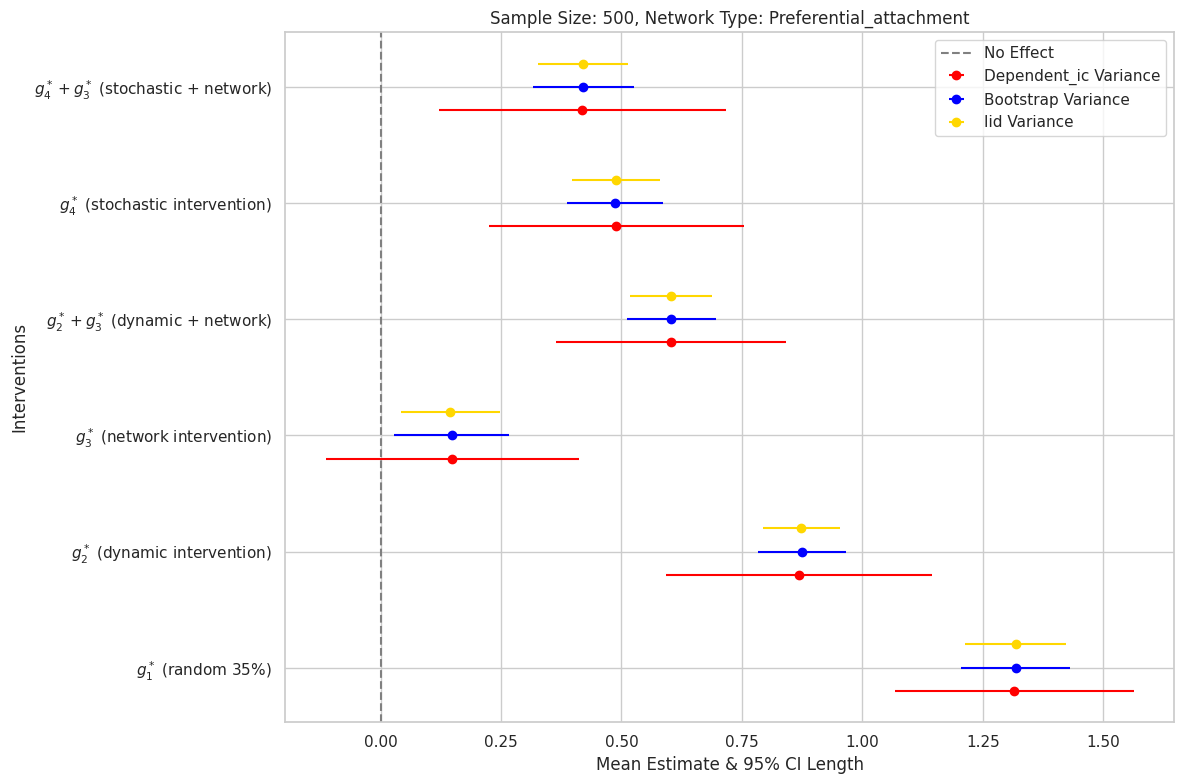

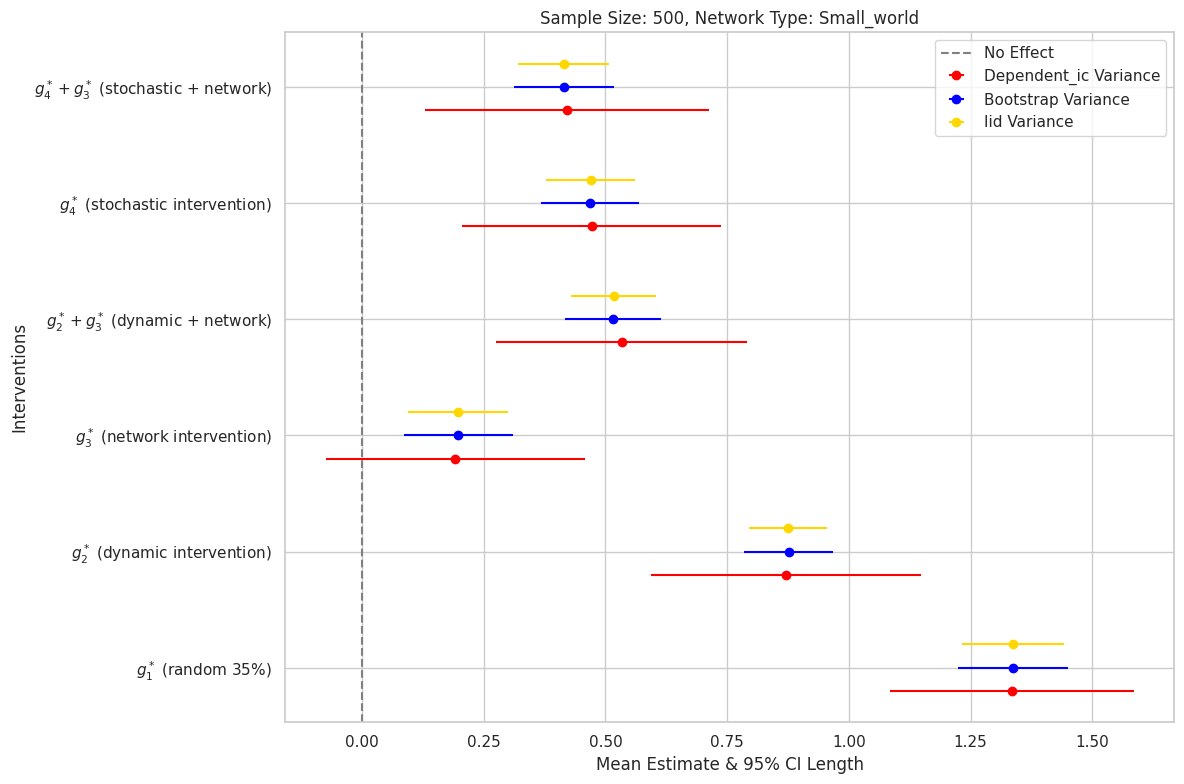

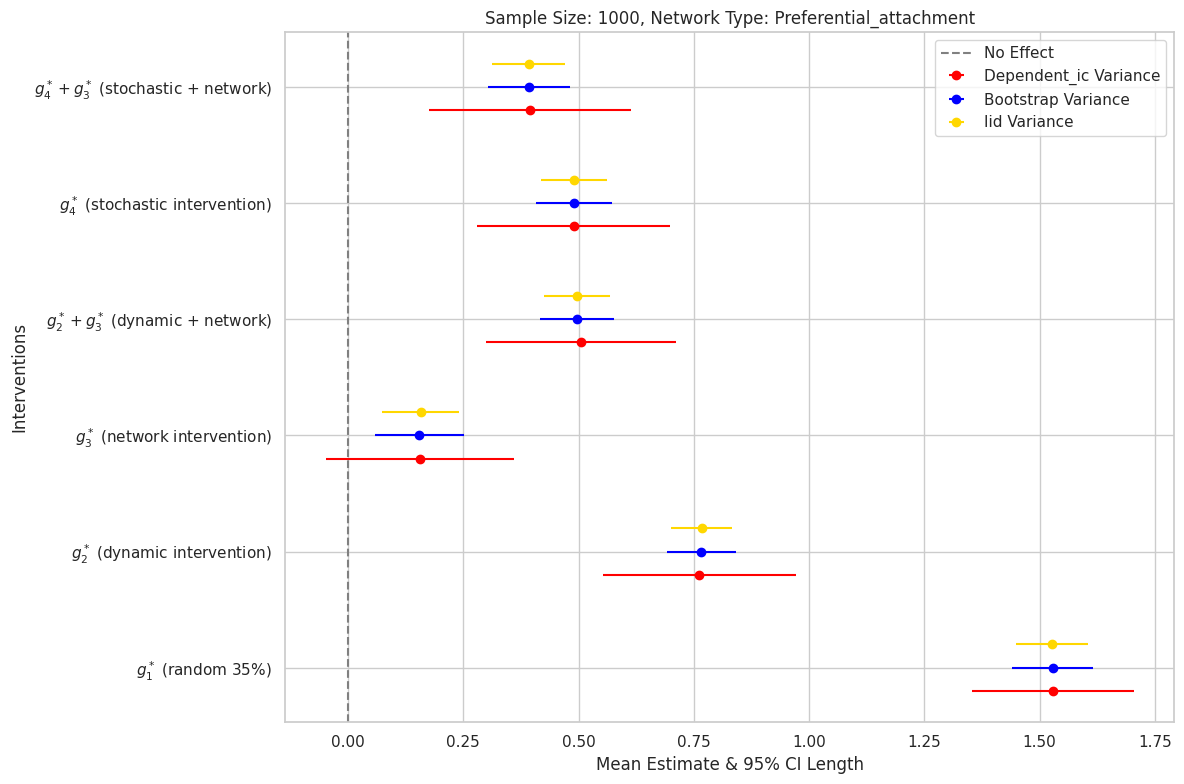

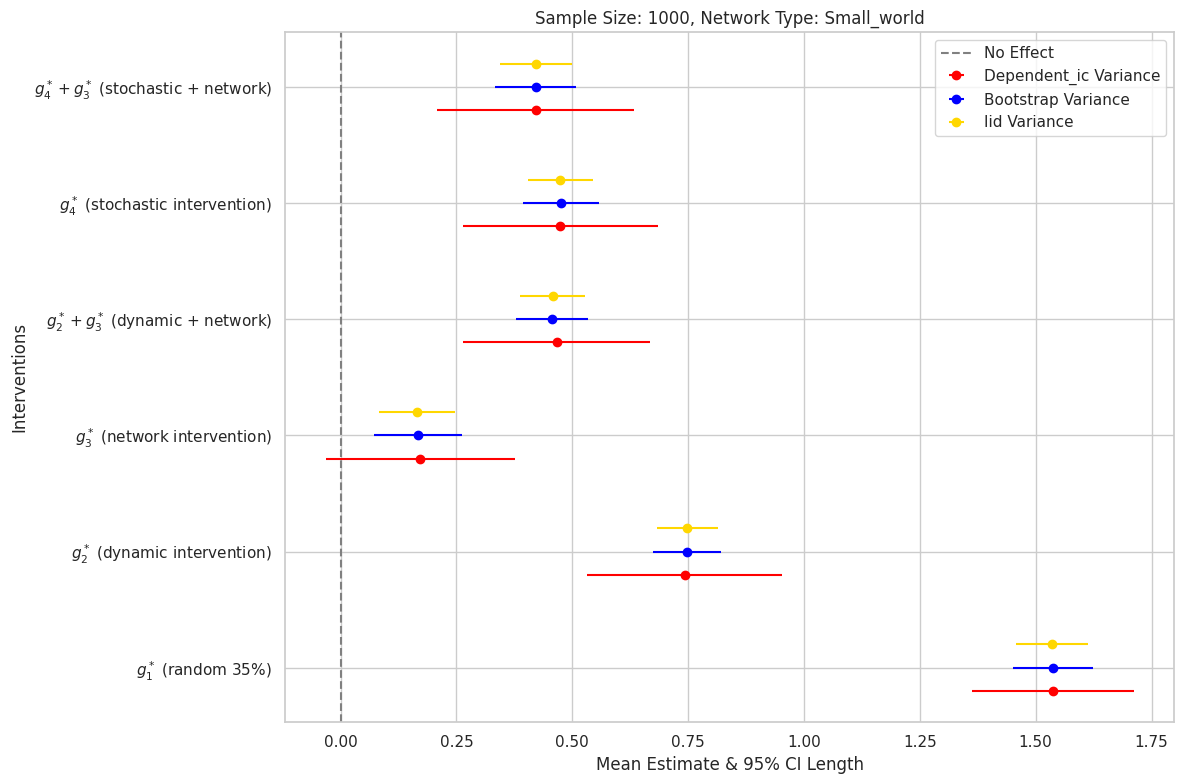

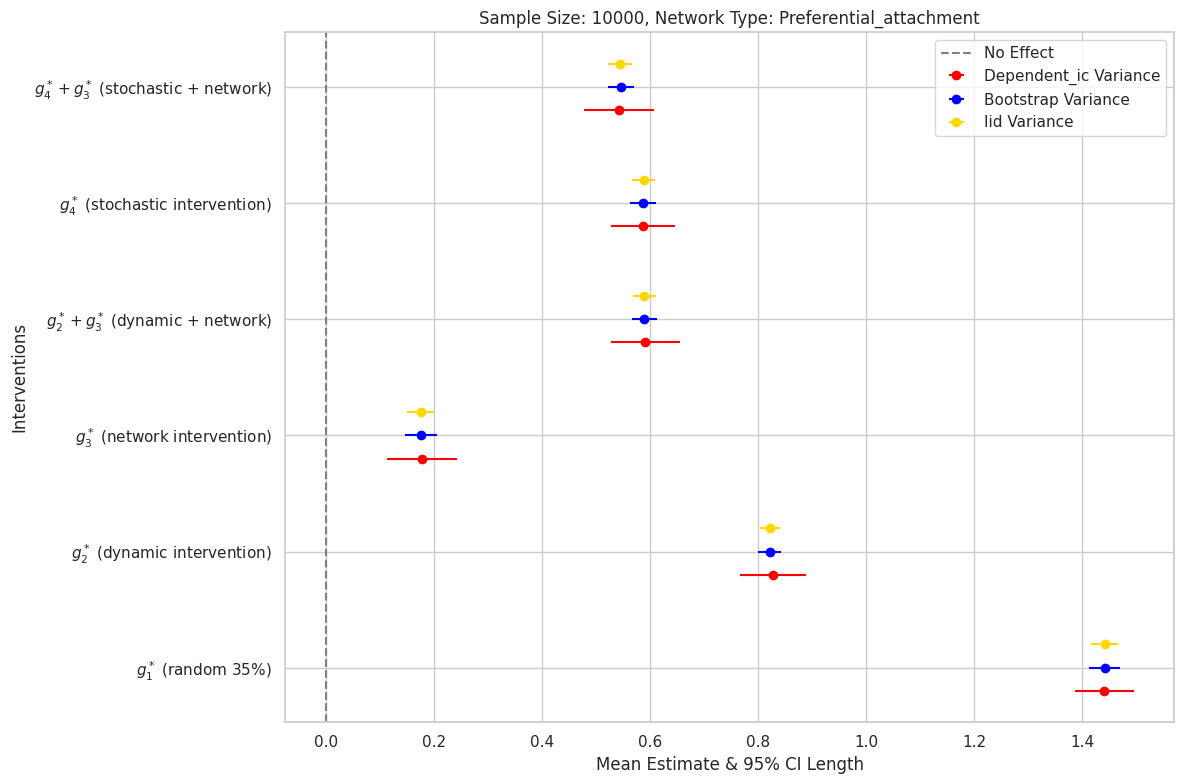

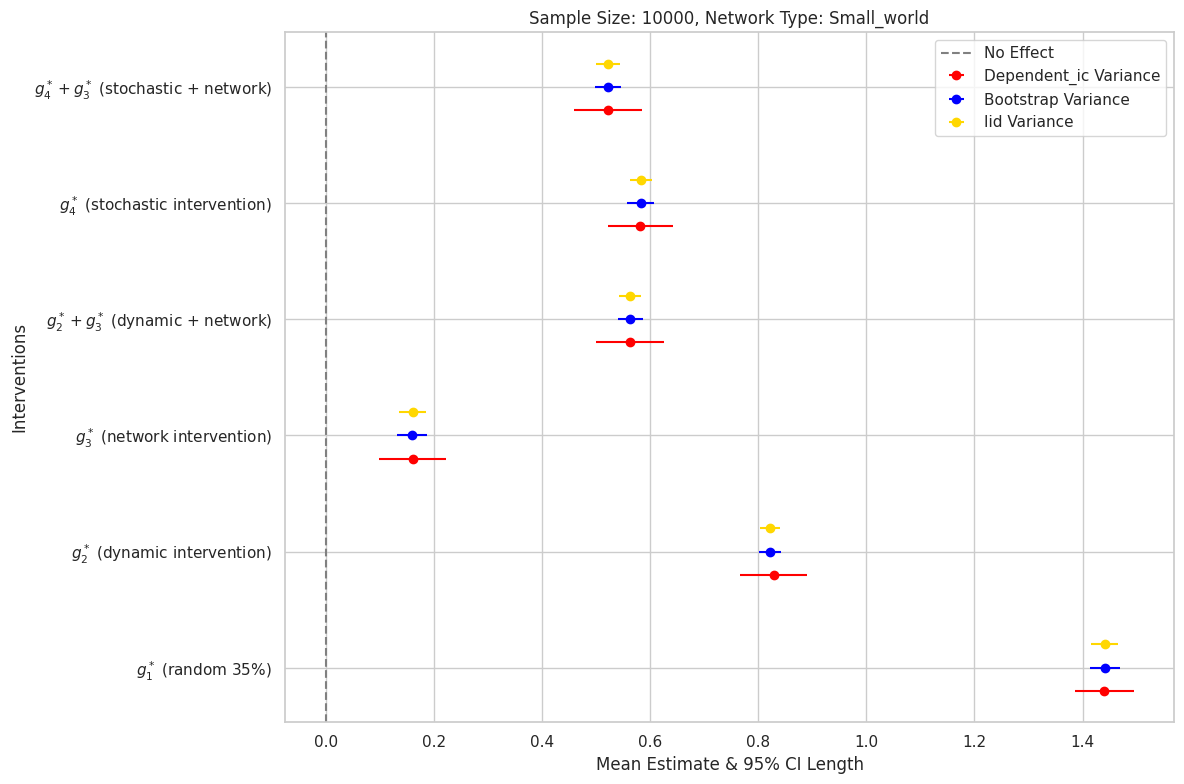

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
from tqdm import tqdm

# Helper Function: Generate a Preferential Attachment Network
def generate_preferential_attachment_network(n, m, seed=None):
    return nx.barabasi_albert_graph(n, m, seed=seed)

# Helper Function: Generate a Small-World Network
def generate_small_world_network(n, k, p, seed=None):
    return nx.newman_watts_strogatz_graph(n, k, p, seed=seed)

# Helper Function: Simulate Node-Level Data and Outcomes
def simulate_network_data(G, p_treatment=0.35, dynamic_threshold=0.5, network_influence=0.2):
    np.random.seed(42)
    n = len(G.nodes)
    data = pd.DataFrame(index=range(n))

    # Simulate covariates
    data['baseline'] = np.random.normal(0, 1, n)
    data['covariate_2'] = np.random.uniform(-1, 1, n)
    data['covariate_3'] = np.random.binomial(1, 0.3, n)

    # Simulate latent effects and direct transmission
    latent_variable = np.random.normal(0, 1, n)
    data['latent_effect'] = latent_variable
    neighbors_treatment = np.array([
        np.mean([latent_variable[neighbor] for neighbor in G.neighbors(node)])
        if len(list(G.neighbors(node))) > 0 else 0
        for node in G.nodes
    ])

    # Treatment assignments
    data['treatment_random'] = np.random.binomial(1, p_treatment, n)
    data['treatment_dynamic'] = (data['baseline'] > dynamic_threshold).astype(int)
    data['treatment_network'] = (neighbors_treatment > network_influence).astype(int)
    data['treatment_combined'] = (data['treatment_dynamic'] | data['treatment_network']).astype(int)

    # Stochastic treatment: Probability proportional to baseline covariate
    probabilities = 1 / (1 + np.exp(-2 * data['baseline']))  # Sigmoid of baseline covariate
    data['stochastic_treatment'] = np.random.binomial(1, probabilities)

    # Combined stochastic and network-based intervention
    data['stochastic_network_combined'] = (
        (data['stochastic_treatment'] | data['treatment_network']).astype(int)
    )

    # Outcome generation
    data['outcome'] = (
        1.5 * data['treatment_random'] +
        0.5 * data['baseline'] +
        0.3 * data['covariate_2'] +
        0.7 * data['covariate_3'] +
        network_influence * neighbors_treatment +
        np.random.normal(0, 1, n)
    )
    return data

# TMLE Estimation Function
def estimate_tmle(data, treatment_col, outcome_col, covariates):
    # Exposure model
    X_exposure = data[covariates]
    A = data[treatment_col]
    ps_model = LogisticRegression(solver='lbfgs')
    ps_model.fit(X_exposure, A)
    data['ps'] = ps_model.predict_proba(X_exposure)[:, 1]

    # Outcome model
    X_outcome = pd.concat([data[covariates], data[[treatment_col]]], axis=1)
    Y = data[outcome_col]
    outcome_model = LinearRegression()
    outcome_model.fit(X_outcome, Y)
    data['Y_pred'] = outcome_model.predict(X_outcome)

    # TMLE targeting step
    clever_covariate = (A - data['ps']) / (data['ps'] * (1 - data['ps']))
    epsilon = np.sum(clever_covariate * (Y - data['Y_pred'])) / np.sum(clever_covariate**2)
    data['Y_tilde'] = data['Y_pred'] + epsilon * clever_covariate

    # Effect and variance
    treated = data[data[treatment_col] == 1]['Y_tilde']
    untreated = data[data[treatment_col] == 0]['Y_tilde']
    effect = treated.mean() - untreated.mean()
    var_treated = treated.var() / len(treated)
    var_untreated = untreated.var() / len(untreated)
    variance = var_treated + var_untreated
    return effect, variance, data

# Variance Estimation Methods
def compute_variance(data, treatment_col, outcome_col, method='dependent_ic', num_bootstrap=1000):
    if method == 'dependent_ic':
        tmle_bootstrap_estimates = []
        for _ in range(num_bootstrap):
            sampled_data = data.sample(frac=0.8, replace=True)
            effect, _, _ = estimate_tmle(
                sampled_data, treatment_col, outcome_col,
                covariates=['baseline', 'covariate_2', 'covariate_3']
            )
            tmle_bootstrap_estimates.append(effect)
        mean_estimate = np.mean(tmle_bootstrap_estimates)
        variance = np.var(tmle_bootstrap_estimates)
    elif method == 'bootstrap':
        bootstrap_estimates = []
        for _ in range(num_bootstrap):
            sampled_data = data.sample(frac=0.8, replace=True)
            treated = sampled_data[sampled_data[treatment_col] == 1]['Y_tilde']
            untreated = sampled_data[sampled_data[treatment_col] == 0]['Y_tilde']
            bootstrap_estimates.append(treated.mean() - untreated.mean())
        mean_estimate = np.mean(bootstrap_estimates)
        variance = np.var(bootstrap_estimates)
    elif method == 'iid':
        treated = data[data[treatment_col] == 1]['Y_tilde']
        untreated = data[data[treatment_col] == 0]['Y_tilde']
        var_treated = treated.var() / len(treated)
        var_untreated = untreated.var() / len(untreated)
        mean_estimate = treated.mean() - untreated.mean()
        variance = var_treated + var_untreated
    else:
        raise ValueError("Invalid method specified for variance computation.")
    return mean_estimate, variance

# Visualization Function
def visualize_results_by_sample_and_network(results_df):
    interventions_labels = {
        'treatment_random': r"$g_1^*$ (random 35%)",
        'treatment_dynamic': r"$g_2^*$ (dynamic intervention)",
        'treatment_network': r"$g_3^*$ (network intervention)",
        'treatment_combined': r"$g_2^* + g_3^*$ (dynamic + network)",
        'stochastic_treatment': r"$g_4^*$ (stochastic intervention)",
        'stochastic_network_combined': r"$g_4^* + g_3^*$ (stochastic + network)"
    }
    methods_colors = {'dependent_ic': 'red', 'bootstrap': 'blue', 'iid': 'gold'}
    method_offsets = {'dependent_ic': -0.2, 'bootstrap': 0, 'iid': 0.2}

    sample_sizes = results_df['Sample Size'].unique()
    network_types = results_df['Network Type'].unique()

    for sample_size in sample_sizes:
        for network_type in network_types:
            subset = results_df[(results_df['Sample Size'] == sample_size) &
                                (results_df['Network Type'] == network_type)]

            plt.figure(figsize=(12, 8))
            for method in subset['Method'].unique():
                method_data = subset[subset['Method'] == method]
                y_positions = np.arange(len(method_data)) + method_offsets[method]

                plt.errorbar(
                    method_data['Effect'],
                    y_positions,
                    xerr=method_data['CI Length'],
                    fmt='o',
                    label=f"{method.capitalize()} Variance",
                    color=methods_colors[method]
                )

            plt.yticks(
                np.arange(len(subset['Intervention'].unique())),
                [interventions_labels[i] for i in subset['Intervention'].unique()]
            )
            plt.axvline(0, color='gray', linestyle='--', label="No Effect")
            plt.xlabel("Mean Estimate & 95% CI Length")
            plt.ylabel("Interventions")
            plt.title(f"Sample Size: {sample_size}, Network Type: {network_type.capitalize()}")
            plt.legend()
            plt.tight_layout()
            plt.show()

# Main Simulation Function
def run_simulation():
    sample_sizes = [500, 1000,10000]
    interventions = [
        'treatment_random',
        'treatment_dynamic',
        'treatment_network',
        'treatment_combined',
        'stochastic_treatment',
        'stochastic_network_combined'  # New intervention
    ]
    variance_methods = ['dependent_ic', 'bootstrap', 'iid']
    network_types = ['preferential_attachment', 'small_world']
    results = []

    for n in tqdm(sample_sizes):
        for network_type in network_types:
            if network_type == 'preferential_attachment':
                G = generate_preferential_attachment_network(n, m=3, seed=42)
            elif network_type == 'small_world':
                G = generate_small_world_network(n, k=4, p=0.1, seed=42)

            data = simulate_network_data(G)
            for intervention in interventions:
                effect_tmle, variance_tmle, updated_data = estimate_tmle(
                    data, treatment_col=intervention, outcome_col='outcome',
                    covariates=['baseline', 'covariate_2', 'covariate_3']
                )
                for method in variance_methods:
                    effect, variance = compute_variance(updated_data, intervention, 'outcome', method=method)
                    ci_length = 1.96 * np.sqrt(variance)
                    results.append({
                        'Sample Size': n,
                        'Network Type': network_type,
                        'Intervention': intervention,
                        'Method': method,
                        'Effect': effect,
                        'CI Length': ci_length,
                    })

    results_df = pd.DataFrame(results)
    visualize_results_by_sample_and_network(results_df)

# Run the Simulation
run_simulation()


In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
from tqdm import tqdm

# Helper Function: Generate a Preferential Attachment Network
def generate_preferential_attachment_network(n, m, seed=None):
    return nx.barabasi_albert_graph(n, m, seed=seed)

# Helper Function: Generate a Small-World Network
def generate_small_world_network(n, k, p, seed=None):
    return nx.newman_watts_strogatz_graph(n, k, p, seed=seed)

# Helper Function: Generate a High-Degree Network
def generate_high_degree_network(n, avg_degree, network_type='preferential_attachment', seed=None):
    if network_type == 'preferential_attachment':
        return nx.barabasi_albert_graph(n, avg_degree // 2, seed=seed)
    elif network_type == 'small_world':
        return nx.newman_watts_strogatz_graph(n, avg_degree, p=0.1, seed=seed)
    else:
        raise ValueError("Unsupported network type.")

# Helper Function: Simulate Node-Level Data and Outcomes
def simulate_network_data(G, p_treatment=0.35, dynamic_threshold=0.5, network_influence=0.2):
    np.random.seed(42)
    n = len(G.nodes)
    data = pd.DataFrame(index=range(n))

    # Simulate covariates
    data['baseline'] = np.random.normal(0, 1, n)
    data['covariate_2'] = np.random.uniform(-1, 1, n)
    data['covariate_3'] = np.random.binomial(1, 0.3, n)

    # Simulate latent effects and direct transmission
    latent_variable = np.random.normal(0, 1, n)
    data['latent_effect'] = latent_variable
    neighbors_treatment = np.array([
        np.mean([latent_variable[neighbor] for neighbor in G.neighbors(node)])
        if len(list(G.neighbors(node))) > 0 else 0
        for node in G.nodes
    ])

    # Treatment assignments
    data['treatment_random'] = np.random.binomial(1, p_treatment, n)
    data['treatment_dynamic'] = (data['baseline'] > dynamic_threshold).astype(int)
    data['treatment_network'] = (neighbors_treatment > network_influence).astype(int)
    data['treatment_combined'] = (data['treatment_dynamic'] | data['treatment_network']).astype(int)

    # Stochastic treatment: Probability proportional to baseline covariate
    probabilities = 1 / (1 + np.exp(-2 * data['baseline']))  # Sigmoid of baseline covariate
    data['stochastic_treatment'] = np.random.binomial(1, probabilities)

    # Combined stochastic and network-based intervention
    data['stochastic_network_combined'] = (
        (data['stochastic_treatment'] | data['treatment_network']).astype(int)
    )

    # Outcome generation
    data['outcome'] = (
        1.5 * data['treatment_random'] +
        0.5 * data['baseline'] +
        0.3 * data['covariate_2'] +
        0.7 * data['covariate_3'] +
        network_influence * neighbors_treatment +
        np.random.normal(0, 1, n)
    )
    return data

# TMLE Estimation Function
def estimate_tmle(data, treatment_col, outcome_col, covariates):
    # Exposure model
    X_exposure = data[covariates]
    A = data[treatment_col]
    ps_model = LogisticRegression(solver='lbfgs')
    ps_model.fit(X_exposure, A)
    data['ps'] = ps_model.predict_proba(X_exposure)[:, 1]

    # Outcome model
    X_outcome = pd.concat([data[covariates], data[[treatment_col]]], axis=1)
    Y = data[outcome_col]
    outcome_model = LinearRegression()
    outcome_model.fit(X_outcome, Y)
    data['Y_pred'] = outcome_model.predict(X_outcome)

    # TMLE targeting step
    clever_covariate = (A - data['ps']) / (data['ps'] * (1 - data['ps']))
    epsilon = np.sum(clever_covariate * (Y - data['Y_pred'])) / np.sum(clever_covariate**2)
    data['Y_tilde'] = data['Y_pred'] + epsilon * clever_covariate

    # Effect and variance
    treated = data[data[treatment_col] == 1]['Y_tilde']
    untreated = data[data[treatment_col] == 0]['Y_tilde']
    effect = treated.mean() - untreated.mean()
    var_treated = treated.var() / len(treated)
    var_untreated = untreated.var() / len(untreated)
    variance = var_treated + var_untreated
    return effect, variance, data

# Variance Estimation Methods
def compute_variance(data, treatment_col, outcome_col, method='dependent_ic', num_bootstrap=1000):
    if method == 'dependent_ic':
        tmle_bootstrap_estimates = []
        for _ in range(num_bootstrap):
            sampled_data = data.sample(frac=0.8, replace=True)
            effect, _, _ = estimate_tmle(
                sampled_data, treatment_col, outcome_col,
                covariates=['baseline', 'covariate_2', 'covariate_3']
            )
            tmle_bootstrap_estimates.append(effect)
        mean_estimate = np.mean(tmle_bootstrap_estimates)
        variance = np.var(tmle_bootstrap_estimates)
    elif method == 'bootstrap':
        bootstrap_estimates = []
        for _ in range(num_bootstrap):
            sampled_data = data.sample(frac=0.8, replace=True)
            treated = sampled_data[sampled_data[treatment_col] == 1]['Y_tilde']
            untreated = sampled_data[sampled_data[treatment_col] == 0]['Y_tilde']
            bootstrap_estimates.append(treated.mean() - untreated.mean())
        mean_estimate = np.mean(bootstrap_estimates)
        variance = np.var(bootstrap_estimates)
    elif method == 'iid':
        treated = data[data[treatment_col] == 1]['Y_tilde']
        untreated = data[data[treatment_col] == 0]['Y_tilde']
        var_treated = treated.var() / len(treated)
        var_untreated = untreated.var() / len(untreated)
        mean_estimate = treated.mean() - untreated.mean()
        variance = var_treated + var_untreated
    else:
        raise ValueError("Invalid method specified for variance computation.")
    return mean_estimate, variance

# Visualization Function
def visualize_high_degree_results(results_df):
    interventions_labels = {
        'treatment_random': "Random (35%)",
        'treatment_dynamic': "Dynamic Intervention",
        'treatment_network': "Network Intervention",
        'treatment_combined': "Dynamic + Network",
        'stochastic_treatment': "Stochastic Intervention",
        'stochastic_network_combined': "Stochastic + Network"
    }
    methods_colors = {'dependent_ic': 'red', 'bootstrap': 'blue', 'iid': 'green'}

    avg_degrees = results_df['Average Degree'].unique()
    network_types = results_df['Network Type'].unique()

    for intervention in results_df['Intervention'].unique():
        plt.figure(figsize=(12, 8))
        for network_type in network_types:
            subset = results_df[(results_df['Intervention'] == intervention) &
                                (results_df['Network Type'] == network_type)]

            for method in subset['Method'].unique():
                method_data = subset[subset['Method'] == method]
                plt.errorbar(
                    method_data['Average Degree'],
                    method_data['Effect'],
                    yerr=method_data['CI Length'],
                    fmt='o-',
                    label=f"{network_type.capitalize()} - {method.capitalize()}",
                    color=methods_colors[method]
                )

        plt.title(f"Effect Size for {intervention}")
        plt.xlabel("Average Degree (Number of Friends)")
        plt.ylabel("Effect Size (Mean Estimate)")
        plt.axhline(0, color='gray', linestyle='--', label="No Effect")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Main Simulation Function
def run_high_degree_simulation_with_stochastic():
    sample_size = 1000
    avg_degrees = [3, 5, 10, 20, 50]  # Increasing the average number of friends
    interventions = [
        'treatment_random',
        'treatment_dynamic',
        'treatment_network',
        'treatment_combined',
        'stochastic_treatment',
        'stochastic_network_combined'  # Include stochastic cases
    ]
    variance_methods = ['dependent_ic', 'bootstrap', 'iid']
    network_types = ['preferential_attachment', 'small_world']
    results = []

    for avg_degree in tqdm(avg_degrees):
        for network_type in network_types:
            G = generate_high_degree_network(sample_size, avg_degree, network_type=network_type, seed=42)
            data = simulate_network_data(G, network_influence=0.2)

            for intervention in interventions:
                effect_tmle, variance_tmle, updated_data = estimate_tmle(
                    data, treatment_col=intervention, outcome_col='outcome',
                    covariates=['baseline', 'covariate_2', 'covariate_3']
                )
                for method in variance_methods:
                    effect, variance = compute_variance(updated_data, intervention, 'outcome', method=method)
                    ci_length = 1.96 * np.sqrt(variance)
                    results.append({
                        'Average Degree': avg_degree,
                        'Network Type': network_type,
                        'Intervention': intervention,
                        'Method': method,
                        'Effect': effect,
                        'CI Length': ci_length,
                    })

    results_df = pd.DataFrame(results)
    visualize_high_degree_results(results_df)

# Run the Simulation
run_high_degree_simulation_with_stochastic()


KeyboardInterrupt: 

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
from tqdm import tqdm

# Helper Function: Generate a Preferential Attachment Network
def generate_preferential_attachment_network(n, m, seed=None):
    return nx.barabasi_albert_graph(n, m, seed=seed)

# Helper Function: Generate a Small-World Network
def generate_small_world_network(n, k, p, seed=None):
    return nx.newman_watts_strogatz_graph(n, k, p, seed=seed)

# Helper Function: Simulate Node-Level Data with High-Degree Influence
def simulate_network_data_with_hub_influence(G, p_treatment=0.35, dynamic_threshold=0.5, network_influence=0.2):
    np.random.seed(42)
    n = len(G.nodes)
    data = pd.DataFrame(index=range(n))

    # Simulate covariates
    data['baseline'] = np.random.normal(0, 1, n)
    data['covariate_2'] = np.random.uniform(-1, 1, n)
    data['covariate_3'] = np.random.binomial(1, 0.3, n)

    # Simulate latent effects and direct transmission
    latent_variable = np.random.normal(0, 1, n)
    data['latent_effect'] = latent_variable
    degrees = np.array([G.degree[node] for node in G.nodes])
    data['degree'] = degrees

    # Identify hub nodes (top 10% by degree)
    hub_threshold = np.percentile(degrees, 90)
    data['is_hub'] = (degrees > hub_threshold).astype(int)

    # Neighbor treatment influence
    neighbors_treatment = np.array([
        np.mean([latent_variable[neighbor] for neighbor in G.neighbors(node)])
        if len(list(G.neighbors(node))) > 0 else 0
        for node in G.nodes
    ])

    # Treatment assignments
    data['treatment_random'] = np.random.binomial(1, p_treatment, n)
    data['treatment_dynamic'] = (data['baseline'] > dynamic_threshold).astype(int)
    data['treatment_network'] = (neighbors_treatment > network_influence).astype(int)
    data['treatment_combined'] = (data['treatment_dynamic'] | data['treatment_network']).astype(int)

    # High-degree treatment (more likely for hub nodes)
    treatment_prob_hub = 0.7 * data['is_hub'] + p_treatment * (1 - data['is_hub'])
    data['treatment_hub'] = np.random.binomial(1, treatment_prob_hub)

    # Outcome generation with amplified hub influence
    hub_influence = data['is_hub'] * 3.0  # Amplified influence for hub nodes
    neighbor_effect = np.array([
        network_influence * np.sum(data.loc[list(G.neighbors(node)), 'treatment_combined']) / max(len(list(G.neighbors(node))), 1)
        for node in G.nodes
    ])
    data['outcome_with_hub_influence'] = (
        1.5 * data['treatment_random'] +
        0.5 * data['baseline'] +
        0.3 * data['covariate_2'] +
        0.7 * data['covariate_3'] +
        neighbor_effect +
        hub_influence +
        np.random.normal(0, 1, n)
    )
    return data

# Simulation for Preferential Attachment vs Small-World Networks
def simulate_preferential_vs_smallworld(network_size=1000, m_preferential=15, k_smallworld=8, p_smallworld=0.1):
    network_types = ['preferential_attachment', 'small_world']
    interventions = ['treatment_random', 'treatment_dynamic', 'treatment_network', 'treatment_combined', 'treatment_hub']
    variance_methods = ['dependent_ic', 'bootstrap', 'iid']
    results = []

    for network_type in tqdm(network_types, desc="Simulating Network Types"):
        if network_type == 'preferential_attachment':
            G = generate_preferential_attachment_network(network_size, m=m_preferential, seed=42)
        elif network_type == 'small_world':
            G = generate_small_world_network(network_size, k=k_smallworld, p=p_smallworld, seed=42)

        # Simulate data with hub influence
        data = simulate_network_data_with_hub_influence(G)

        # Iterate over interventions and compute TMLE effects
        for intervention in interventions:
            effect_tmle, variance_tmle, updated_data = estimate_tmle(
                data, treatment_col=intervention, outcome_col='outcome_with_hub_influence',
                covariates=['baseline', 'covariate_2', 'covariate_3', 'degree']
            )
            for method in variance_methods:
                effect, variance = compute_variance(updated_data, intervention, 'outcome_with_hub_influence', method=method)
                ci_length = 1.96 * np.sqrt(variance)
                results.append({
                    'Network Type': network_type,
                    'Intervention': intervention,
                    'Method': method,
                    'Effect': effect,
                    'CI Length': ci_length,
                })

    return pd.DataFrame(results)

# Visualization: Same Format as Earlier
def visualize_too_many_friends_with_all_variances(results_df):
    interventions_labels = {
        'treatment_random': r"$g_1^*$ (random 35%)",
        'treatment_dynamic': r"$g_2^*$ (dynamic intervention)",
        'treatment_network': r"$g_3^*$ (network intervention)",
        'treatment_combined': r"$g_2^* + g_3^*$ (dynamic + network)",
        'treatment_hub': r"$g_5^*$ (high-degree intervention)"
    }
    methods_colors = {'dependent_ic': 'red', 'bootstrap': 'blue', 'iid': 'gold'}
    method_offsets = {'dependent_ic': -0.2, 'bootstrap': 0, 'iid': 0.2}
    network_types = results_df['Network Type'].unique()

    for network_type in network_types:
        subset = results_df[results_df['Network Type'] == network_type]

        plt.figure(figsize=(12, 8))
        for method in subset['Method'].unique():
            method_data = subset[subset['Method'] == method]
            for idx, intervention in enumerate(method_data['Intervention'].unique()):
                intervention_data = method_data[method_data['Intervention'] == intervention]
                mean_effect = intervention_data['Effect'].values[0]
                ci_length = intervention_data['CI Length'].values[0]
                plt.errorbar(
                    mean_effect,
                    idx + method_offsets[method],
                    xerr=ci_length,
                    fmt='o',
                    label=f"{method.capitalize()} Variance" if idx == 0 else "",
                    color=methods_colors[method]
                )

        plt.yticks(
            range(len(subset['Intervention'].unique())),
            [interventions_labels[i] for i in subset['Intervention'].unique()]
        )
        plt.axvline(0, color='gray', linestyle='--', label="No Effect")
        plt.xlabel("Mean Estimate & 95% CI Length")
        plt.ylabel("Interventions")
        plt.title(f"Effect of Too Many Friends Across Variances - {network_type.capitalize()} Network")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Run Simulation and Visualization
results_df = simulate_preferential_vs_smallworld(network_size=1000)
visualize_too_many_friends_with_all_variances(results_df)
